<img src="./images/QISKit-c.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="250 px" align="left">

## _*Entanglement revisited*_ 

The latest version of this notebook is available on https://github.com/IBM/qiskit-sdk-py/tree/master/scripts.

For more information about how to use the Quantum Experience consult the [Quantum Experience tutorials](https://quantumexperience.ng.bluemix.net/qstage/#/tutorial?sectionId=c59b3710b928891a1420190148a72cce&pageIndex=0) or check-out the [community](https://quantumexperience.ng.bluemix.net/qstage/#/community).

***
### Contributors
Jay Gambetta, Antonio Córcoles

## Entanglement

In [superposition and entanglement](scripts/superposition_and_entanglement.ipynb) we introduced you to the concept of entanglement. We made the quantum state $|\psi\rangle= (|00\rangle+|11\rangle)/\sqrt{2}$ and showed that (up to experimental noise) the system has perfect correlations in both the computation basis and the superpostion basis. This means that if $q_0$ is measured in state $|0\rangle$ then we know $q_1$ is in this state, and furthermore if $q_0$ is measured in state $|+\rangle$ then we know $q_1$ is in this state.

To understand the implications of this in a little bit more detail lets introduce the concept of an observable. An observable is a Hermitian matrix where the real eigenvalues represent the outcome of the experiment and the eigenvectors are the states the system is projected in under measurement. That is $ A$ is given by
  

$$  A = \sum_j a_j|a_j\rangle\langle a_j|$$ 

where $|a_j\rangle$ is the eigenvector of the observable with result $a_j$. This expectation value of this observable is given by 

$$\langle  A \rangle  = \sum_j a_j |\langle \psi  |a_j\rangle|^2  = \sum_j a_j \mathrm{Pr}(a_j|\psi)$$

and we see there is the standard relationship between average (expectation value) and probability. 

For a two qubit system the following important two-outcome ($\pm1$) single qubit observables are 

$$ Z= |0\rangle\langle 0| - |1\rangle\langle 1|$$ 
$$ X= |+\rangle\langle +| - |-\rangle\langle -|$$ 

which can be extended to the two-qubit space to give 

$$\langle  I\otimes  Z\rangle =\mathrm{Pr}(00|\psi) - \mathrm{Pr}(01|\psi) +  \mathrm{Pr}(10|\psi)- \mathrm{Pr}(11|\psi)$$ 
$$\langle  Z\otimes  I\rangle =\mathrm{Pr}(00|\psi) + \mathrm{Pr}(01|\psi) -  \mathrm{Pr}(10|\psi)- \mathrm{Pr}(11|\psi)$$ 
$$\langle  Z\otimes  Z\rangle =\mathrm{Pr}(00|\psi) - \mathrm{Pr}(01|\psi) -  \mathrm{Pr}(10|\psi)+ \mathrm{Pr}(11|\psi)$$ 

$$\langle  I\otimes  X\rangle =\mathrm{Pr}(++|\psi) - \mathrm{Pr}(+-|\psi) +  \mathrm{Pr}(-+|\psi)- \mathrm{Pr}(--|\psi)$$ 
$$\langle  X\otimes  I\rangle =\mathrm{Pr}(++|\psi) + \mathrm{Pr}(+-|\psi) -  \mathrm{Pr}(-+|\psi)- \mathrm{Pr}(--|\psi)$$ 
$$\langle  X\otimes  X\rangle =\mathrm{Pr}(++|\psi) - \mathrm{Pr}(+-|\psi) -  \mathrm{Pr}(-+|\psi)+ \mathrm{Pr}(--|\psi)$$ 


$$\langle  Z\otimes  X\rangle =\mathrm{Pr}(0+|\psi) - \mathrm{Pr}(0-|\psi) -  \mathrm{Pr}(1+|\psi)+ \mathrm{Pr}(1-|\psi)$$ 
$$\langle  X\otimes  Z\rangle =\mathrm{Pr}(+0|\psi) - \mathrm{Pr}(+1|\psi) -  \mathrm{Pr}(-0|\psi)+ \mathrm{Pr}(-1|\psi)$$ 

In [17]:
#Checking the version of PYTHON we only support 3 at the moment
import sys
if sys.version_info < (3,0):
    raise Exception("Please use Python version 3 or greater.")
    
#usefull additional packages 
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.linalg
%matplotlib inline
import time

#importing the QX and QISKit 
from IBMQuantumExperience import IBMQuantumExperience
import sys
sys.path.append("..")
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.extensions.standard import x, h, cx, s, u3, barrier

#some usefull functions for running a program, plotting, and getting the data
from qhelpers.misc import run_program
from qhelpers.misc import program_to_text
from qhelpers.misc import combine_jobs
from qhelpers.misc import get_data
from qhelpers.basicplotter import plot_histogram
from qhelpers.misc import average_data

#Set up the API to communitcate to the QX
import Qconfig
api = IBMQuantumExperience.IBMQuantumExperience(Qconfig.APItoken, Qconfig.config)

Recall to make the Bell state $|\psi\rangle= (|00\rangle+|11\rangle)/\sqrt{2}$ from the initial state $|00\rangle$, the quantum circuit first applies a Hadmard on $q_0$ and then a CNOT from $q_0$ to $q_1$. On the Quantum Experience this is done by using the script for measurement of the above expectation values we have to run four different experiments with measurements in the standard basis, superposition basis, and a combination of both.

In [2]:
device = 'real' # the device to run on
shots = 1024    #the number of shots in the experiment. 

#quantum circuit to make bell state 
q = QuantumRegister("q", 2)
c = ClassicalRegister("c", 2)
bell = QuantumCircuit(q, c)
bell.h(q[0])
bell.cx(q[0],q[1])

# quantum circuit to measure q in standard basis 
measureZZ = QuantumCircuit(q, c)
measureZZ.measure(q[0], c[0])
measureZZ.measure(q[1], c[1])

# quantum circuit to measure q in superposition basis 
measureXX = QuantumCircuit(q, c)
measureXX.h(q[0])
measureXX.h(q[1])
measureXX.measure(q[0], c[0])
measureXX.measure(q[1], c[1])

# quantum circuit to measure ZX
measureZX = QuantumCircuit(q, c)
measureZX.h(q[0])
measureZX.measure(q[0], c[0])
measureZX.measure(q[1], c[1])

# quantum circuit to measure XZ
measureXZ = QuantumCircuit(q, c)
measureXZ.h(q[1])
measureXZ.measure(q[0], c[0])
measureXZ.measure(q[1], c[1])

program = [bell+measureZZ, bell+measureZX, bell+measureXX, bell+measureXZ]

print(program_to_text(program))
out = run_program(program,api,device,shots,max_credits=3)
jobids=[out['id']]
results=combine_jobs(jobids, api, wait=20, timeout=240)  

OPENQASM 2.0;
include "qelib1.inc";
qreg q[2];
creg c[2];
u2(0.0,3.141592653589793) q[0];
cx q[0],q[1];
measure q[1] -> c[1];
measure q[0] -> c[0];


OPENQASM 2.0;
include "qelib1.inc";
qreg q[2];
creg c[2];
u2(0.0,3.141592653589793) q[0];
cx q[0],q[1];
u2(0.0,3.141592653589793) q[0];
measure q[1] -> c[1];
measure q[0] -> c[0];


OPENQASM 2.0;
include "qelib1.inc";
qreg q[2];
creg c[2];
u2(0.0,3.141592653589793) q[0];
cx q[0],q[1];
u2(0.0,3.141592653589793) q[0];
u2(0.0,3.141592653589793) q[1];
measure q[1] -> c[1];
measure q[0] -> c[0];


OPENQASM 2.0;
include "qelib1.inc";
qreg q[2];
creg c[2];
u2(0.0,3.141592653589793) q[0];
cx q[0],q[1];
u2(0.0,3.141592653589793) q[1];
measure q[1] -> c[1];
measure q[0] -> c[0];



status = {'RUNNING': 1} (0 seconds)
status = {'COMPLETED': 1} (20 seconds)


In [3]:
obsevableIZ ={'00000': 1, '00001': -1, '00010': 1, '00011': -1}
obsevableZI ={'00000': 1, '00001': 1, '00010': -1, '00011': -1}
obsevableZZ ={'00000': 1, '00001': -1, '00010': -1, '00011': 1}

obsevableIZ_ideal ={'00': 1, '01': -1, '10': 1, '11': -1}
obsevableZI_ideal ={'00': 1, '01': 1, '10': -1, '11': -1}
obsevableZZ_ideal ={'00': 1, '01': -1, '10': -1, '11': 1}

In [4]:
print("IZ = " + str(average_data(get_data(results,0),obsevableIZ)))
print("ZI = " + str(average_data(get_data(results,0),obsevableZI)))
print("ZZ = " + str(average_data(get_data(results,0),obsevableZZ)))

print("IX = " + str(average_data(get_data(results,2),obsevableIZ)))
print("XI = " + str(average_data(get_data(results,2),obsevableZI)))
print("XX = " + str(average_data(get_data(results,2),obsevableZZ)))

print("ZX = " + str(average_data(get_data(results,1),obsevableZZ)))
print("XZ = " + str(average_data(get_data(results,3),obsevableZZ)))

IZ = 0.0703125
ZI = 0.107421875
ZZ = 0.822265625
IX = 0.1953125
XI = 0.212890625
XX = 0.826171875
ZX = 0.0
XZ = 0.0546875


Here we see that for the state $|\psi\rangle= (|00\rangle+|11\rangle)/\sqrt{2}$ that within experimental error expectation values are


Observable    | Expected value |Observable    | Expected value|Observable    | Expected value
------------- | -------------  | ------------- | ------------- | ------------- | -------------
ZZ  | 1   |XX  | 1  | ZX  | 0 
ZI  | 0   |XI  | 0  | XZ  | 0
IZ  | 0   |IX  | 0  |   |

If we assume there is a hidden variable $\lambda$ and the follow assumptions 

* _Locality_: No information can travel faster than the speed of light. There is a hidden variable $\lambda$ that defines all the correlations so that  $$\langle A\otimes B\rangle = \sum_\lambda P(\lambda) A(\lambda) B(\lambda)$$ 
                      
* _Realism_: All observables have a definite value independent of the measurement ($A(\lambda)=\pm1$ etc).

can we describe these observations.  --- The answer is yes! 

Lets assume $\lambda$ has two bits each occurring randomly with probably 1/4 then the following predefined table would explain all the above observables

$\lambda$    | Z (qubit 1) |Z (qubit 2)    | X (qubit 1)| X (qubit 2)   
------------- | -------------  | ------------- | ------------- | ------------- 
00  | 1 | 1 | 1 | 1  
01  | 1 | 1 |-1 |-1  
10  |-1 |-1 |-1 |-1    
11  |-1 |-1 | 1 | 1  

however there are some states where this is not true. This was first observed by John Stewart Bell in 1964.  He proposed a theorem that suggests that there are no hidden variables in quantum mechanics. At the core of Bell's theorem is the famous Bell inequality. Here, we'll use a refined version of this inequality (known as the CHSH inequality, derived by John Clauser, Michael Horne, Abner Shimony, and Richard Holt in 1969) to demonstrate Bell's proposal 

## CHSH inequality 


In the CHSH inequality we measure the correlator of the four observables: $A$ and $A'$ on $q_0$ and $B$ and $B'$ on $q_1$ which have eigenvalues $\pm 1$. The CHSH inequality says that no local hidden variable theory can have  

$$|C|>2$$ 

where 

$$C = \langle B\otimes A\rangle + \langle B\otimes A'\rangle+\langle B'\otimes A'\rangle-\langle B'\otimes A\rangle$$

Under the locality and realism assumtion above  $C$ becomes 

$$C = \sum_\lambda P(\lambda) \{ B(\lambda) [ A(\lambda)+A'(\lambda)] + B'(\lambda) [ A'(\lambda)-A(\lambda)]$$
                      
and $[A(\lambda)+A'(\lambda)]=2$ (or 0) while $[A'(\lambda)-A(\lambda)]=0$ (or 2) respectively. That is, $|C|=2$, and noise will only make this smaller. 
 
If we measure a number greater than 2 then the above assumptions can not be valid, and this is one of those astonishing counterintuitive ideas one must accept in the quantum world.

For simplicity we choose these observables to be 

 $$C = \langle Z\otimes Z\rangle + \langle Z\otimes X\rangle+\langle X\otimes X\rangle-\langle X\otimes Z\rangle$$

Z is measured in the computational basis and X in the superposition basis ($H$ is applied before measurement) and the input state $$|\psi(\theta)\rangle = I\otimes Y(\theta)\frac{|00\rangle + |11\rangle}{\sqrt(2)} = \frac{\cos(\theta/2)|00\rangle + \cos(\theta/2)|11\rangle+\sin(\theta/2)|01\rangle-\sin(\theta/2)|10\rangle}{\sqrt{2}}$$ is swept vs $\theta$. 
 
Note that the following demonstration of CHSH is not loophole-free. 

In [5]:
CHSH = lambda x : x[0]+x[1]+x[2]-x[3]

In [6]:
program = []
xdata=[]

program_end = [measureZZ, measureZX, measureXX, measureXZ]

for jj in range(30):
    theta = 2.0*np.pi*jj/30
    bell_middle = QuantumCircuit(q, c)
    bell_middle.u3(theta,0,0,q[0])
    for i in range(4):
        program.append(bell+bell_middle+program_end[i])
    xdata.append(theta)
    


In [7]:
print(program_to_text(program[0:8]))

OPENQASM 2.0;
include "qelib1.inc";
qreg q[2];
creg c[2];
u2(0.0,3.141592653589793) q[0];
cx q[0],q[1];
u3(0.0,0.0,0.0) q[0];
measure q[1] -> c[1];
measure q[0] -> c[0];


OPENQASM 2.0;
include "qelib1.inc";
qreg q[2];
creg c[2];
u2(0.0,3.141592653589793) q[0];
cx q[0],q[1];
u3(0.0,0.0,0.0) q[0];
u2(0.0,3.141592653589793) q[0];
measure q[1] -> c[1];
measure q[0] -> c[0];


OPENQASM 2.0;
include "qelib1.inc";
qreg q[2];
creg c[2];
u2(0.0,3.141592653589793) q[0];
cx q[0],q[1];
u3(0.0,0.0,0.0) q[0];
u2(0.0,3.141592653589793) q[0];
u2(0.0,3.141592653589793) q[1];
measure q[1] -> c[1];
measure q[0] -> c[0];


OPENQASM 2.0;
include "qelib1.inc";
qreg q[2];
creg c[2];
u2(0.0,3.141592653589793) q[0];
cx q[0],q[1];
u3(0.0,0.0,0.0) q[0];
u2(0.0,3.141592653589793) q[1];
measure q[1] -> c[1];
measure q[0] -> c[0];


OPENQASM 2.0;
include "qelib1.inc";
qreg q[2];
creg c[2];
u2(0.0,3.141592653589793) q[0];
cx q[0],q[1];
u3(0.20943951023932,0.0,0.0) q[0];
measure q[1] -> c[1];
measure q[0] -> c[0];



In [8]:
device = 'simulator'
shots = 1024

program_list=[program[0:40],program[40:80],program[80:120]]

jobids = []
for p in program_list:
    out=run_program(p,api,device,shots,max_credits=3)
    jobids.append(out['id'])
    
r=combine_jobs(jobids, api, wait=5, timeout=240)

CHSH_data_sim = []
for j in range(0,len(r['qasms']),4):
    temp=[]
    temp.append(average_data(get_data(r,j+0),obsevableZZ_ideal))
    temp.append(average_data(get_data(r,j+1),obsevableZZ_ideal))
    temp.append(average_data(get_data(r,j+2),obsevableZZ_ideal))
    temp.append(average_data(get_data(r,j+3),obsevableZZ_ideal))
    CHSH_data_sim.append(CHSH(temp))

status = {'COMPLETED': 2, 'RUNNING': 1} (0 seconds)
status = {'COMPLETED': 3} (5 seconds)


In [9]:
device = 'real'
shots = 1024

program = []
xdata2=[]

for jj in range(10):
    theta = 2.0*np.pi*jj/10
    bell_middle = QuantumCircuit(q, c)
    bell_middle.u3(theta,0,0,q[0])
    for i in range(4):
        program.append(bell+bell_middle+program_end[i])
    xdata2.append(theta)


out = run_program(program,api,device,shots,max_credits=3)
jobids=[out['id']]
r=combine_jobs(jobids, api, wait=20, timeout=240)  

CHSH_data_real = []
for j in range(0, len(r['qasms']), 4):
    temp=[]
    temp.append(average_data(get_data(r,j+0),obsevableZZ))
    temp.append(average_data(get_data(r,j+1),obsevableZZ))
    temp.append(average_data(get_data(r,j+2),obsevableZZ))
    temp.append(average_data(get_data(r,j+3),obsevableZZ))
    CHSH_data_real.append(CHSH(temp))

status = {'RUNNING': 1} (0 seconds)
status = {'RUNNING': 1} (20 seconds)
status = {'RUNNING': 1} (40 seconds)
status = {'COMPLETED': 1} (60 seconds)


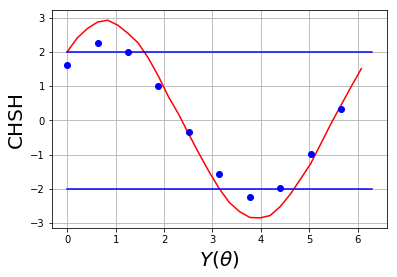

In [10]:
plt.plot(xdata, CHSH_data_sim, 'r-', xdata2, CHSH_data_real, 'bo')
plt.plot([0, 2*np.pi], [2, 2], 'b-')
plt.plot([0, 2*np.pi], [-2, -2], 'b-')
plt.grid()
plt.ylabel('CHSH', fontsize=20)
plt.xlabel(r'$Y(\theta)$', fontsize=20)
plt.show()

The graph created by running the next cell compares the simulated data (sinusoidal line) and the data from the real experiment. The graph also gives lines at $\pm 2$ for reference.

Here is the saved CHSH data. 

In [11]:
print(CHSH_data_real)

[1.603515625, 2.248046875, 1.994140625, 1.013671875, -0.330078125, -1.578125, -2.23046875, -1.97265625, -0.98828125, 0.32421875]


Despite the presence of loopholes in our demonstration, we can see that this experiment is compatible with quantum mechanics as a theory with no local hidden variables.

## Mermin's test
In case the violation of Bell's inequality (CHSH) by two qubits is not enough for you to believe in quantum mechanics, we can generalize to a more stringent set of tests with three qubits which can a single shot violation (rather than average). We can explore beyond two-qubit entanglement and generate Greenberger-Horne-Zeilinger states. A well-known three-qubit case is Mermin's inequality, and here in this notebook we work through such a test.

An example of a three-qubit GHZ state is $|\psi\rangle = \left (|000\rangle+|111\rangle\right)/\sqrt{2}$. You can see this is a further generalization of a Bell-state and if measured, should give $|000\rangle$ half the time and $|111 \rangle$ the other half of the time.

OPENQASM 2.0;
include "qelib1.inc";
qreg q[3];
creg c[3];
u2(0.0,3.141592653589793) q[0];
cx q[0],q[1];
cx q[0],q[2];
measure q[2] -> c[2];
measure q[1] -> c[1];
measure q[0] -> c[0];



status = {'RUNNING': 1} (0 seconds)
status = {'RUNNING': 1} (20 seconds)
status = {'COMPLETED': 1} (40 seconds)


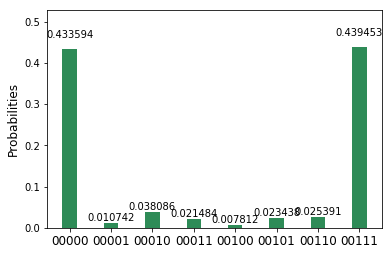

In [13]:
#quantum circuit to make GHZ state 
q = QuantumRegister("q", 3)
c = ClassicalRegister("c", 3)
ghz = QuantumCircuit(q, c)
ghz.h(q[0])
ghz.cx(q[0],q[1])
ghz.cx(q[0],q[2])

# quantum circuit to measure q in standard basis 
measureZZZ = QuantumCircuit(q, c)
measureZZZ.measure(q[0], c[0])
measureZZZ.measure(q[1], c[1])
measureZZZ.measure(q[2], c[2])

program = [ghz+measureZZZ]

print(program_to_text(program))

out = run_program(program,api,device,shots,max_credits=3)
jobids=[out['id']]
results=combine_jobs(jobids, api, wait=20, timeout=240)   

data=get_data(results,0)
plot_histogram(data)

## Three-box game

Now suppose we have three independent systems,$\{A,B,C\}$, for which we can query two particular questions $X$ and $Y$. In each case, either query can give $+1$ or $-1$. Is it possible to choose some state of the three boxes such that we can satisfy the following four conditions, $X_A Y_B Y_C = 1$, $Y_A X_B Y_C =1$, $Y_A Y_B X_C = 1$, and $X_A X_B X_C = -1$. Choosing classical states, this can be shown to be impossible. Yet a 3-qubit GHZ state can satsify all four conditions.

In [14]:
MerminM = lambda x : x[0]*x[1]*x[2]*x[3]

In [15]:
observable ={'00000': 1, '00001': -1, '00010': -1, '00011': 1, '00100': -1, '00101': 1, '00110': 1, '00111': -1}

In [22]:
# quantum circuit to measure q XXX 
measureXXX = QuantumCircuit(q, c)
measureXXX.h(q[0])
measureXXX.h(q[1])
measureXXX.h(q[2])
measureXXX.measure(q[0], c[0])
measureXXX.measure(q[1], c[1])
measureXXX.measure(q[2], c[2])

# quantum circuit to measure q XYY
measureXYY = QuantumCircuit(q, c)
measureXYY.s(q[1]).inverse()
measureXYY.s(q[2]).inverse()
measureXYY.h(q[0])
measureXYY.h(q[1])
measureXYY.h(q[2])
measureXYY.measure(q[0], c[0])
measureXYY.measure(q[1], c[1])
measureXYY.measure(q[2], c[2])

# quantum circuit to measure q YXY
measureYXY = QuantumCircuit(q, c)
measureYXY.s(q[0]).inverse()
measureYXY.s(q[2]).inverse()
measureYXY.h(q[0])
measureYXY.h(q[1])
measureYXY.h(q[2])
measureYXY.measure(q[0], c[0])
measureYXY.measure(q[1], c[1])
measureYXY.measure(q[2], c[2])

# quantum circuit to measure q YYX
measureYYX = QuantumCircuit(q, c)
measureYYX.s(q[0]).inverse()
measureYYX.s(q[1]).inverse()
measureYYX.h(q[0])
measureYYX.h(q[1])
measureYYX.h(q[2])
measureYYX.measure(q[0], c[0])
measureYYX.measure(q[1], c[1])
measureYYX.measure(q[2], c[2])

program = [ghz+measureXXX,ghz+measureYYX,ghz+measureYXY,ghz+measureXYY]

out = run_program(program,api,device,shots,max_credits=3)
jobids=[out['id']]
r=combine_jobs(jobids, api, wait=20, timeout=240)   

status = {'RUNNING': 1} (0 seconds)
status = {'COMPLETED': 1} (20 seconds)


In [23]:
temp=[]
temp.append(average_data(get_data(r,0),observable))
temp.append(average_data(get_data(r,1),observable))
temp.append(average_data(get_data(r,2),observable))
temp.append(average_data(get_data(r,3),observable))
print(temp)
print(MerminM(temp))

[0.654296875, -0.56640625, -0.5234375, -0.54296875]
-0.1053276879247278


The above shows that the average statistics are not consistent with a local hidden variable theory. To show it with single shots below we run 50 single experiments with each experiement is chosen randomly and the outcome is saved. If there was a local hidden variable theory all of these outcomes would be $+1$.

In [53]:
device = 'real'
program_singleshot=[]
for j in range(0, 50):
    r=np.random.randint(4)
    program_singleshot.append(program[r])
    

In [54]:
out = run_program(program_singleshot,api,device,1,max_credits=3)
jobids=[out['id']]
r=combine_jobs(jobids, api, wait=20, timeout=240) 

status = {'RUNNING': 1} (0 seconds)
status = {'COMPLETED': 1} (20 seconds)


In [59]:
temp=[]
for j in range(0, 50):
    temp.append(average_data(get_data(r,j),observable))

In [69]:
outcomes = np.histogram(temp,bins=2)
outcomes

(array([34, 16]), array([-1.,  0.,  1.]))